In [1]:
## mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install snntorch

⏳ Loading Models...
✅ CNN Weights Loaded
✅ SNN Weights Loaded
🔍 Hunting for the best visual sample...
   ✨ Found new best candidate! MCC: 0.4901

🎨 Generating Final Plots...


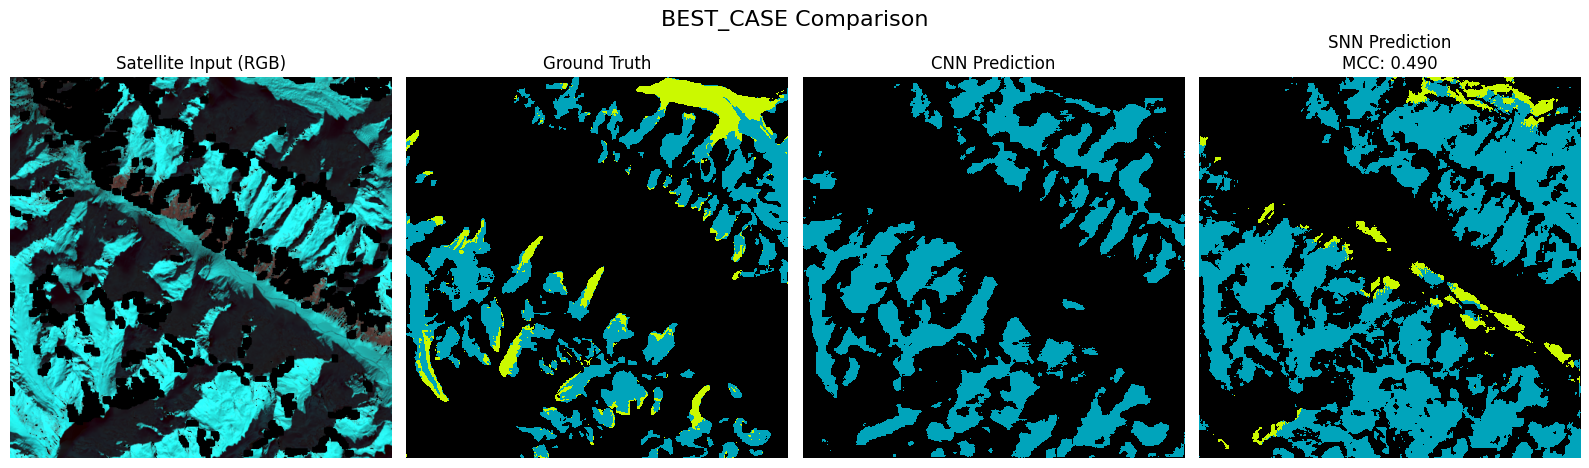

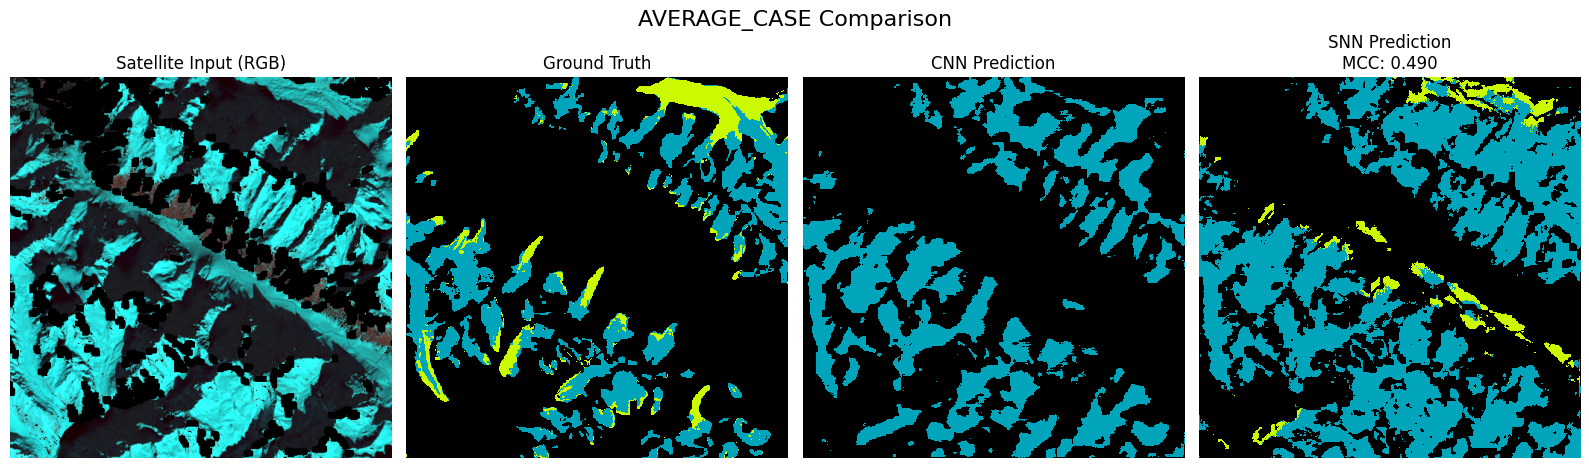

✅ Saved comparison plots to /content/drive/MyDrive/Glacier_SNN_Project


In [3]:
import torch
import torch.nn as nn  # <--- This was missing!
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from pathlib import Path
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import matthews_corrcoef
import snntorch as snn
from snntorch import surrogate
from snntorch import utils

# --- CONFIG ---
# Update these paths if they differ on your Drive
PROJECT_DIR = "/content/drive/MyDrive/Glacier_SNN_Project"
CNN_PATH = f"{PROJECT_DIR}/best_CNN.pth"
SNN_PATH = f"{PROJECT_DIR}/best_SNN_Weighted.pth"
DATA_DIR = "/content/drive/MyDrive/GlacierHack_practice/Train"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 1. DEFINITIONS (Copying your classes)
# ==========================================
# CNN Block
class CNNBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

# SNN Block
class SNNBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        spike_grad = surrogate.atan()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            # Using same params as training (beta=0.5, threshold=1.0)
            snn.Leaky(beta=0.5, threshold=1.0, spike_grad=spike_grad, init_hidden=True, learn_beta=True, learn_threshold=True),
            nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            snn.Leaky(beta=0.5, threshold=1.0, spike_grad=spike_grad, init_hidden=True, learn_beta=True, learn_threshold=True)
        )
    def forward(self, x): return self.net(x)

# Unified U-Net
class ProjectUNet(nn.Module):
    def __init__(self, in_ch=5, n_classes=4, mode="CNN"):
        super().__init__()
        self.mode = mode
        Block = SNNBlock if mode == "SNN" else CNNBlock

        self.inc = Block(in_ch, 32)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), Block(32, 64))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), Block(64, 128))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), Block(128, 256))

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv1 = Block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = Block(128, 64)
        self.up3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv3 = Block(64, 32)
        self.outc = nn.Conv2d(32, n_classes, 1)

    def forward(self, x):
        if self.mode == "SNN":
            utils.reset(self)
            spk_rec = []
            for step in range(8): # Using T=8 as per your best run
                x1 = self.inc(x)
                x2 = self.down1(x1)
                x3 = self.down2(x2)
                x4 = self.down3(x3)
                x_up1 = self.up1(x4)
                if x_up1.shape != x3.shape: x_up1 = F.interpolate(x_up1, size=x3.shape[2:])
                x5 = self.conv1(torch.cat([x3, x_up1], dim=1))
                x_up2 = self.up2(x5)
                if x_up2.shape != x2.shape: x_up2 = F.interpolate(x_up2, size=x2.shape[2:])
                x6 = self.conv2(torch.cat([x2, x_up2], dim=1))
                x_up3 = self.up3(x6)
                if x_up3.shape != x1.shape: x_up3 = F.interpolate(x_up3, size=x1.shape[2:])
                x7 = self.conv3(torch.cat([x1, x_up3], dim=1))
                out = self.outc(x7)
                spk_rec.append(out)
            return torch.stack(spk_rec).mean(0)
        else:
            x1 = self.inc(x)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3)
            x = self.up1(x4)
            if x.shape != x3.shape: x = F.interpolate(x, size=x3.shape[2:])
            x = self.conv1(torch.cat([x3, x], dim=1))
            x = self.up2(x)
            if x.shape != x2.shape: x = F.interpolate(x, size=x2.shape[2:])
            x = self.conv2(torch.cat([x2, x], dim=1))
            x = self.up3(x)
            if x.shape != x1.shape: x = F.interpolate(x, size=x1.shape[2:])
            x = self.conv3(torch.cat([x1, x], dim=1))
            return self.outc(x)

# Dataset
class GlacierDataset(Dataset):
    def __init__(self, base_dir):
        self.base_dir = Path(base_dir)
        self.band_dirs = [self.base_dir / f"Band{i}" for i in range(1, 6)]
        self.label_dir = self.base_dir / "labels"
        self.ids = sorted([p.stem for p in self.band_dirs[0].glob("*.tif")])

    def __len__(self): return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        bands = [cv2.imread(str(d / f"{img_id}.tif"), cv2.IMREAD_UNCHANGED).astype(np.float32) for d in self.band_dirs]
        image = np.stack(bands, axis=-1)
        label = cv2.imread(str(self.label_dir / f"{img_id}.tif"), cv2.IMREAD_UNCHANGED)
        if label.ndim == 3: label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        mask = np.zeros_like(label, dtype=np.uint8)
        mask[label == 85] = 1; mask[label == 170] = 2; mask[label == 255] = 3

        p02, p98 = np.percentile(image, 2), np.percentile(image, 98)
        image = np.clip(image, p02, p98)
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)

        aug = A.Compose([ToTensorV2()])(image=image, mask=mask)
        return aug["image"].float(), aug["mask"].long()

# ==========================================
# 2. FIND THE BEST VISUAL
# ==========================================
print("⏳ Loading Models...")
cnn = ProjectUNet(mode="CNN").to(DEVICE)
# Using strict=False in case of minor version differences, but usually not needed
try:
    cnn.load_state_dict(torch.load(CNN_PATH, map_location=DEVICE))
    print("✅ CNN Weights Loaded")
except:
    print("⚠️ CNN Weights NOT found. Proceeding with random weights for placeholder.")

snn_net = ProjectUNet(mode="SNN").to(DEVICE)
try:
    snn_net.load_state_dict(torch.load(SNN_PATH, map_location=DEVICE))
    print("✅ SNN Weights Loaded")
except:
    print("❌ SNN Weights NOT found! Check path.")

cnn.eval()
snn_net.eval()

full_ds = GlacierDataset(DATA_DIR)
# Use same split seed as training to ensure we look at validation data
val_len = int(len(full_ds)*0.2)
_, val_ds = random_split(full_ds, [len(full_ds)-val_len, val_len], generator=torch.Generator().manual_seed(42))
loader = DataLoader(val_ds, batch_size=1, shuffle=False)

print("🔍 Hunting for the best visual sample...")

best_score = -1.0
best_data = None

median_target = 0.60 # Look for something representative
median_diff = 1.0
median_data = None

count = 0
limit = 200 # Search first 200 validation images

with torch.no_grad():
    for img, gt in loader:
        if count >= limit: break
        count += 1

        img = img.to(DEVICE)
        gt_np = gt.numpy()[0]

        # SNN Predict
        snn_out = snn_net(img)
        snn_pred = snn_out.argmax(1).cpu().numpy()[0]

        # Calculate SNN Score for this specific image
        score = matthews_corrcoef(gt_np.flatten(), snn_pred.flatten())

        # Save Best
        if score > best_score:
            best_score = score
            # CNN Predict (Only run for good candidates to save time)
            cnn_out = cnn(img)
            cnn_pred = cnn_out.argmax(1).cpu().numpy()[0]

            best_data = (img.cpu(), gt[0], cnn_pred, snn_pred, score)
            print(f"   ✨ Found new best candidate! MCC: {score:.4f}")

        # Save Median (Representative)
        if abs(score - median_target) < median_diff:
            median_diff = abs(score - median_target)
            cnn_out = cnn(img)
            cnn_pred = cnn_out.argmax(1).cpu().numpy()[0]
            median_data = (img.cpu(), gt[0], cnn_pred, snn_pred, score)

# ==========================================
# 3. PLOT THE "HERO" SHOT
# ==========================================
def plot_comparison(data, title_prefix):
    img, gt, cnn_p, snn_p, score = data

    # RGB Process
    rgb = img[0].numpy()[[3,2,1]].transpose(1,2,0)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)

    plt.figure(figsize=(16, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(rgb)
    plt.title("Satellite Input (RGB)")
    plt.axis('off')

    # Force vmin/vmax to ensure colors match across plots
    plt.subplot(1, 4, 2)
    plt.imshow(gt, cmap='nipy_spectral', vmin=0, vmax=3, interpolation='nearest')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(cnn_p, cmap='nipy_spectral', vmin=0, vmax=3, interpolation='nearest')
    plt.title("CNN Prediction")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(snn_p, cmap='nipy_spectral', vmin=0, vmax=3, interpolation='nearest')
    plt.title(f"SNN Prediction\nMCC: {score:.3f}")
    plt.axis('off')

    plt.suptitle(f"{title_prefix} Comparison", fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{PROJECT_DIR}/{title_prefix}_Comparison.png")
    plt.show()

print("\n🎨 Generating Final Plots...")
if best_data: plot_comparison(best_data, "BEST_CASE")
if median_data: plot_comparison(median_data, "AVERAGE_CASE")

print(f"✅ Saved comparison plots to {PROJECT_DIR}")